# Explainer Notebook
This notebook provides the background and our personal motivations for the development of our final project.

Our final project (Article titled **"What Gets The People Going?"**) is an examination of pedestrian activity in inner city Melbourne in conjugation with different weather types. Additionally, the article features a predictive model of pedestrian activity given certain weather inputs.

## Motivation
### What is our dataset?
We've used three datasets:
1. City of Melbourne's Pedestrian Counting System [Source](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Monthly-counts-per-hour/b2ak-trbp?src=featured_banner)
2. The associated Pedestrian Counting System Sensor location dataset [Source](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Sensor-Locations/h57g-5234)
3. Meteostat's weather data from a Melbourne weather station [Source](https://meteostat.net/en/station/94866?t=2015-01-01/2021-12-31)

### Why did we choose this dataset?
We became particularly interested in the Pedestrian activity dataset when we found it and decided we would like to center our project around it. To this end we discussed different ways to cross the data with something else to provide a social or green background to our project.

Ultimately we decided on weather! We thought exploring any eventual corellations between weather and pedestrian activity would make for some interesting discourse.

Then we could look at how temperature, wind and rainfall affected people's decision to walk.
### What was our goal for the end-user experience?
Hard to specify exactly what we wanted for our end-user since we could not tell beforehand what the data would show, but it would be a lie not to say that we were expecting some interesting corellations to point at. Especially rainfall and temperature seemed like factors that could widely affect pedestrian activity, and we wished to point these out to the user in a sort of build-up, where we at first explore the pedestrian data, then cross it with the weather data to suddenly see some cool trends.

Finally, we would have liked to be able to show some rudimentary results of a predictive model, to engage the user in a small if interesting quirky forecasting; "Look, we can tell how many people will walk depending on the weather!"
While by itself somewhat uninteresting, it would at least give rise to some discussion of how such data could be used in events, campaigns and other minor social 'manipulation'.

## Basic Stats

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import folium
from folium import plugins
from folium.plugins import HeatMap

In [2]:
# The location data set of the sensors.
df_s = pd.read_csv('https://www.student.dtu.dk/~s212220/socialData2022/Data/Pedestrian_Counting_System_-_Sensor_Locations.csv')

In [22]:
# The pedestrian data set
df_p = pd.read_csv('https://www.student.dtu.dk/~s212220/socialData2022/Data/Pedestrian_Counting_System_-_Monthly__counts_per_hour_.csv')

In [4]:
# The weather data set
df_w = pd.read_csv('https://www.student.dtu.dk/~s212220/socialData2022/Data/weather_melbourne.csv')

### Let's start with the location of the sensors. Here are some basic information about it:

* 78 rows coresponding to the amount of sensors.
* 10KB
* 11 columns: only bold written columns will be used.
    * **sensor_id**: integers from 1 to 79 correcponting to each row and sensor
    * **sensor_description**: unique categories (78 values) which corespond to the street name the sensors are installed on
    * sensor_name: categorial unique name (78 values) of the senor
    * **installation_date**: dates when the sensor was installed, 60 different values from 2009/01/20 until 2021/09/10
    * **status**: categorial (A = Active, I = Inactive, R = Removed), 71 sensors are active and 7 where removed
    * note: categorial strings, notes on a sensor, 10 different values, the other 69 values are missing
    * direction_1 & direction_2: categorial (North, South, West, East) the two directions the sensors are reading into. Both have 4 missing values
    * **latitude**: distinct real numbers representing the latitude of the sensor, from -37.82401776 until -37.79453802
    * **longitude**: distinct real numbers representing the longitude of the sensor, from 144.9303619 until 144.9746766
    * location: 78 distinct values showing the latitude and longitude together.

An imporant thing to notice is the status.  7 sensors were removed in the past due to construction work or something else. Since we assume that there were no futher data collected from the sensors after their removal, we can still leave them in the dataset. We always have to be aware that the amount of sensors collecting data changes over time. Either to new installed sensors or to removed ones. (While looking at the data points of the removed sensors, it states that 2 of them were removed in 2017, one in 2015 and for the other 4 is no information provided).

In [5]:
df_s.drop(['sensor_name', 'note', 'direction_1', 'direction_2', 'location'], axis=1, inplace=True)

In [6]:
# The maps shows the location of the sensors.
map_loc = folium.Map(location=[-37.8140000, 144.9633200],tiles = "Stamen Toner",
                    zoom_start = 14) 

# Ensure you're handing it floats
df_s['latitude'] = df_s['latitude'].astype(float)
df_s['longitude'] = df_s['longitude'].astype(float)

for index, row in df_s.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['sensor_description']).add_to(map_loc)

# Styling title
loc = 'Corpus Christi'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>Locations of Sensors</b></h3>
             '''.format(loc) 
map_loc.get_root().html.add_child(folium.Element(title_html))

# Display the map
map_loc

The interactive map shows all the locations of the different sensors collecting the pedestrian data. As visible, most of the sensors are located in the inner city and that's where our focus is directed in the project. Each of the sensors provides a description containing the street or corner where they are located. One outlineer can be noticed when zooming out on the map. It's the sensor located on the corner of Macaulay Rd and Bellair St. As we are focusing on the city center and - by having a look at the data - since it was installed at the end of the timeframe of our pedestrian data set on 2021/02/20, we still leave it in the data set but our later maps may not focus on showing it as well.

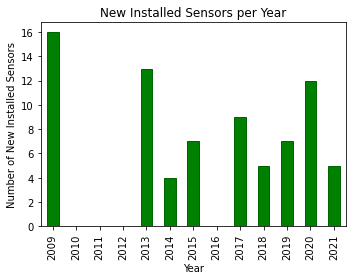

In [7]:
# finding the year of the installation
df_s['Year'] = pd.DatetimeIndex(df_s['installation_date']).year
# adding missing years in range(2009, 2022)
df = pd.DataFrame({'Year': [2010, 2011, 2012, 2016]})
df_s_y = df_s.append(df, ignore_index = True)

# Plot that shows new introduced sensors per year
fig = plt.figure(figsize=(5, 4))
df_s_y.groupby(['Year']).count()['sensor_id'].plot \
    .bar(title='New Installed Sensors per Year', x=range(df_s['Year'].min(),df_s['Year'].max() + 1),
         edgecolor='darkgreen', color = 'green')
# Styling
plt.ylabel('Number of New Installed Sensors');

plt.tight_layout() 
plt.show()

The plot aboth shows when sensors were installed over the years. Covid is a pendemic which hit Melbourne in March 2020 [Source](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Victoria). Until then there were 61 sensors installed. In the futher analytics we will focus on 2019 as a year before covid and 2020 as a representativ of covid.

### Next up, we are providing some important insights to the pedestrian data we used:

* 4176218 rows corresponding to data collected in an hour with one sensor.
* 396.8MB
* 10 columns: only bold written columns will be used.
    * ID: distinct number representing a unique id of the data point from 1 to 4181689
    * **Date_Time**: categorial string value representing the date and time the data point was collected
    * **Year**: 16 different number values representing the year when the data point was collected, from 2009 until 2022
    * **Month**: 12 categorial string values representing the month of the year.
    * **Mdate**: 31 integers from 1 until 31 representing the date of the month.
    * **Day**: 7 categorial string values representing the day of the week.
    * **Time**: 23 integers representing the starting time of the day the data was collected for an hour.
    * **Sensor_ID**: 81 different integers representing the ID of the sensor collecting the data. Reference to the sensor location data set.
    * Sensor_Name: categorial unique name (93 values) of the senor collecting the data
    * **Hourly_Counts**: 6359 different numbers representing the total amount of pedestrians counted during this hour form 0 to 15979

In [23]:
# Dropping unused columns
df_p.drop(['ID', 'Sensor_Name'], axis=1, inplace=True)

With this information, we can see that there is a difference in amount of Sensor_ID and Sensor_Name which should not happen. Since it is only the name which probably relates to a different naming and we do not need this column, we are not looking deeper into that. 

More interesting is the difference between the sensor ids of the pedestrian dataset and the sensor location data set. Let's have a look at that:

In [9]:
# Finding the 3 missing sensors
for s_id in df_p.Sensor_ID.unique():
    if s_id not in df_s.sensor_id.unique():
        print('Sensor ID: ', s_id)

Sensor ID:  84
Sensor ID:  85
Sensor ID:  86


A we can see, the sensor ids 84, 85 and 86 are not appearing in the sensor location data set. We decided to drop the data points collected with these sencors since we are not having enouth information about the senors.

In [24]:
# Cleaning the pedestrian data - deleting the missing sensors activity
df_p = df_p[(df_p.Sensor_ID != 84) & (df_p.Sensor_ID != 85) & (df_p.Sensor_ID != 86)]

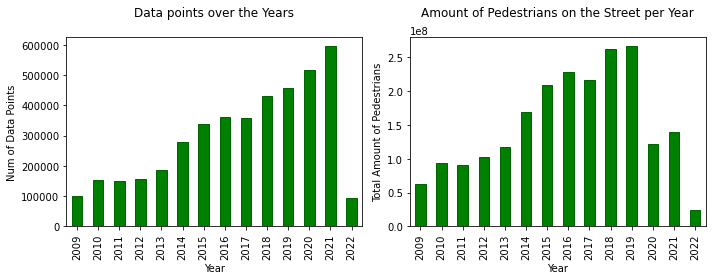

In [12]:
# Plot shows the data points over the year and the amount of pedestrians walking
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
df_p.groupby('Year').count()['Hourly_Counts'].plot \
    .bar(title='Data points over the Years\n', 
         ax = ax[0], edgecolor='darkgreen', color = 'green')
df_p.groupby(['Year']).sum()['Hourly_Counts'].plot \
    .bar(title='Amount of Pedestrians on the Street per Year\n', 
         ax=ax[1], edgecolor='darkgreen', color = 'green')

# Styling
ax[0].set_ylabel('Num of Data Points');
ax[1].set_ylabel('Total Amount of Pedestrians');

plt.tight_layout() 
plt.show()

The collection of data grew over the years for the pedestrian data set. This can be compared with the plot aboth showing the installed sensors. Whenever no new sensors where installed, the collection of data languishs. The amount of pedestrians on the street is mainly growing due to more datapoints but we can see a few unexpected outliners. Looking at 2020 and 2021, we can see a huge drop in the amount of pedestrians on the street while the data points are growing which is due to covid. 
Another small drop can be observed in 2017 which is probably due to the sensors which were removed during that year.

### Finally, we are digging deeper into the weather data set:

* 2557 rows corresponding to each day
* 114KB
* 11 columns: only bold written columns will be used.
    * **date**: distinct categorial value representing the date the data point was collected form 2015/01/01 until 2021/12/31
    * **tavg**: 251 different real numbers representing the average temperature on that day from 4.6 to 34.3 °C
    * **tmin**: 230 different real numbers representing the minimum temperature on that day from -2 to 26.5 °C
    * **tmax**: 305 different real numbers representing the maximum temperature on that day from 8.3 to 46 °C
    * **prcp**: 120 different real numbers representing the percipitation on that day from 0 to 69 mm
    * snow: completly missing
    * **wdir**: 277 different real numbers representing the wind direction on that day from 0 to 360 degrees, 160 missing values
    * **wspd**: 343 different real numbers representing the wind speed on that day from 3.8 to 55.3 km/h, 21 missing values
    * wpgt: comletly missing
    * pres: 358 different real numbers representing the air pressure on that day from 962.2 to 1036.1 hPa, 350 missing values
    * tsun: completly missing
    
Due to either comletly missing all values or not enouth values (14% missing), we decided to drop the columns which are not written in bold. Since we still have some missing values, we will drop the rows having missing values.

In [13]:
# Cleaning the weather data - dropping snow, wpgt, tsun, pres due to too many missing values
df_w = df_w.drop(['snow', 'wpgt', 'pres', 'tsun'], axis=1)
# Drop NaN values of the rest of the culomns
df_w = df_w.dropna()

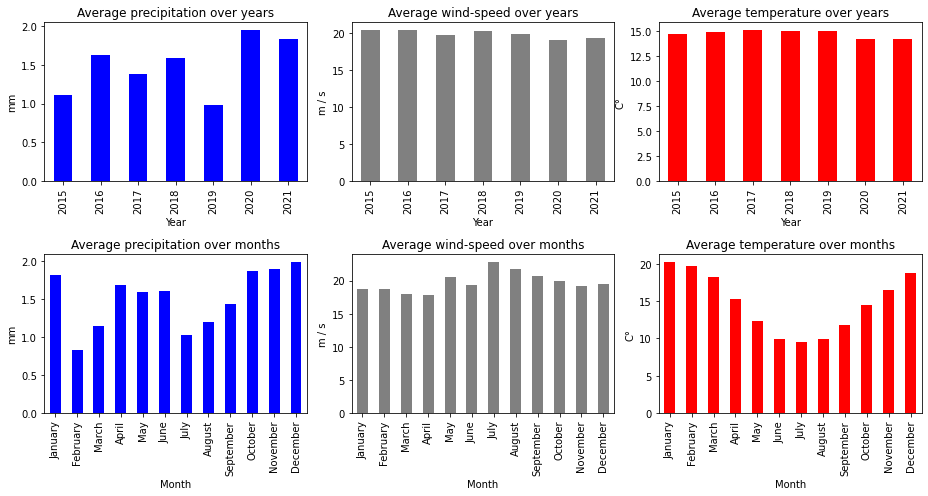

In [14]:
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
# Prefparing the weather data
df_w['Year'] = pd.DatetimeIndex(df_w['date']).year
df_w['MonthNo'] = pd.DatetimeIndex(df_w['date']).month
df_w['Month'] = df_w['MonthNo'].apply(lambda x: months[x-1])
df_w['date'] = pd.DatetimeIndex(df_w['date']).date
df_w['dayofweek'] = pd.DatetimeIndex(df_w['date']).dayofweek

# Creating plots with basic statistics for temperature, wind-speed and percipitation
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(13,7))
df_w['Month'] = pd.Categorical(df_w['Month'], categories=months, ordered=True)

featuresToPlot = ['prcp','wspd','tavg']
titleLabels = ['precipitation','wind-speed','temperature']
colors = ['blue','grey','red']
yUnits = ['mm','m / s','C°']
for n, f in enumerate(featuresToPlot):
    df_w.groupby(df_w['Year']).mean()[f].plot.bar(color = colors[n],title=f'Average {titleLabels[n]} over years', ax = ax[(int(n/3)),(int(n%3))])
    ax[(int(n/3)),(int(n%3))].set_ylabel(yUnits[n]) 
    
for n, f in enumerate(featuresToPlot):
    df_w.groupby(df_w['Month']).mean()[f].plot.bar(color = colors[n],title=f'Average {titleLabels[n]} over months', ax = ax[(int((n+3)/3)),(int((n+3)%3))])
    ax[(int((n+3)/3)),(int((n+3)%3))].set_ylabel(yUnits[n]) 

plt.tight_layout() 
plt.show()

By looking at a few basic plots of the weather data, we can see that 2015 and 2019 where quite dry years. Looking at the rain over months, it reveals a rather unusual structure since there are some hugh drops. We din't expect that but we think its just how weather is. Not always as expected. The other plots show that Melbourne has quite static weather weather over the years with a normal distribution over the months.


## Data Analysis
* Discuss our data analysis and explain what we've learned about the dataset *
TODO

First, we are going to have a closer look at the connection between the pedestrian data and the location of the sensors. We choose a interactive heatmap for this analysis. The selected year is 2019 and we are going to compare January with July since they are opposide months, one in summer and the other one in winter. We plot the whole month.

In [25]:
# getting data frames from January and July in 2019
df_p_19 = df_p.loc[df_p['Year'] == 2019]
df_p_19_ja = df_p_19.loc[df_p_19['Month'] == 'January']
df_p_19_ju = df_p_19.loc[df_p_19['Month'] == 'July']
df_s_location = df_s[['sensor_id', 'latitude', 'longitude']]

In [26]:
# merging the january dataset with the sensors location
df_p_19_ja_g = df_p_19_ja.groupby(['Sensor_ID']).sum()
df_p_19_ja_g.columns = df_p_19_ja_g.columns.str.replace('Hourly_Counts', 'Monthly_Counts')
df_p_19_ja_g = pd.merge(df_p_19_ja_g, df_s_location, left_on="Sensor_ID", right_on="sensor_id").drop('sensor_id', axis=1)
# normalizing the monthly count such that we can easier compute the heat map
MC_sum_ja = df_p_19_ja_g['Monthly_Counts'].sum()
df_p_19_ja_g.Monthly_Counts = (df_p_19_ja_g.Monthly_Counts / MC_sum_ja) * 10000

# merging the july dataset with the sensors location
df_p_19_ju_g = df_p_19_ju.groupby(['Sensor_ID']).sum()
df_p_19_ju_g.columns = df_p_19_ju_g.columns.str.replace('Hourly_Counts', 'Monthly_Counts')
df_p_19_ju_g = pd.merge(df_p_19_ju_g, df_s_location, left_on="Sensor_ID", right_on="sensor_id").drop('sensor_id', axis=1)
# normalizing the monthly count such that we can easier compute the heat map
MC_sum_ju = df_p_19_ju_g['Monthly_Counts'].sum()
df_p_19_ju_g.Monthly_Counts = (df_p_19_ju_g.Monthly_Counts / MC_sum_ju) * 10000

In [27]:
# creating the heat map for january
map_january = folium.Map(location=[-37.8140000, 144.9633200],tiles = "Stamen Toner",
                    zoom_start = 14) 

# Ensure you're handing it floats
df_p_19_ja_g['latitude'] = df_p_19_ja_g['latitude'].astype(float)
df_p_19_ja_g['longitude'] = df_p_19_ja_g['longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df_ja = pd.DataFrame(columns=['latitude',
                    'longitude'])
for index, row in df_p_19_ja_g.iterrows():
    for index in range(0, int(row['Monthly_Counts'])):
        df_row = pd.DataFrame([[row['latitude'],row['longitude']]], columns=['latitude', 'longitude'])
        heat_df_ja = heat_df_ja.append(df_row, ignore_index = True)

# List comprehension to make out list of lists
heat_data_ja = [[row['latitude'],row['longitude']] for index, row in heat_df_ja.iterrows()]

# Styling
loc = 'Corpus Christi'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>Normalized Amount of Pedestrians in January</b></h3>
             '''.format(loc) 
map_january.get_root().html.add_child(folium.Element(title_html))

# Marking outliners
folium.CircleMarker([-37.820178, 144.965089], radius=20, 
                    popup='Southbank',color='red').add_to(map_january)

# Plot it on the map
HeatMap(heat_data_ja, blur=10, radius=15).add_to(map_january)

# Display the map
map_january

In [28]:
# creating the heat map for july
map_july = folium.Map(location=[-37.8140000, 144.9633200],tiles = "Stamen Toner",
                    zoom_start = 14) 

# Ensure you're handing it floats
df_p_19_ju_g['latitude'] = df_p_19_ju_g['latitude'].astype(float)
df_p_19_ju_g['longitude'] = df_p_19_ju_g['longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df_ju = pd.DataFrame(columns=['latitude',
                    'longitude'])
for index, row in df_p_19_ju_g.iterrows():
    for index in range(0, int(row['Monthly_Counts'])):
        df_row = pd.DataFrame([[row['latitude'],row['longitude']]], columns=['latitude', 'longitude'])
        heat_df_ju = heat_df_ju.append(df_row, ignore_index = True)

# List comprehension to make out list of lists
heat_data_ju = [[row['latitude'],row['longitude']] for index, row in heat_df_ju.iterrows()]

# Styling
loc = 'Corpus Christi'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>Normalized Amount of Pedestrians in July</b></h3>
             '''.format(loc) 
map_july.get_root().html.add_child(folium.Element(title_html))

# Marking outliners
folium.CircleMarker([-37.817864, 144.965068], radius=20, 
                    popup='Flinders St - Elizabeth St (East)',color='red').add_to(map_july)
folium.CircleMarker([-37.818990, 144.954507], radius=20, 
                    popup='Spencer St - Collins St',color='red').add_to(map_july)

# Plot it on the map
HeatMap(heat_data_ju, blur=10, radius=15).add_to(map_july)

# Display the map
map_july

The data used for these heatmaps was normalized to skale down the amount of datapoints. As expected the city center is the most flourishing point which can be explained by a lot of sensors and a main attraction throughout the year. Two main points are outstanding between January and July. 

In January the sensor in Southbank is high active meaning recognized a lot of pedestrians while its nearly not visible in July. The people seamed to stay on the other side of the river since a sensor at Flinders St - Elizabeth St (East) seams to recognize a lot more people. The Southbank is a promenade which "has many cafes, restaurants, shops, upmarket hotels, offices, public art and modern apartments." [Source](https://www.melbourne.vic.gov.au/about-melbourne/melbourne-profile/suburbs/Pages/Southbank.aspx) This explains a lot of activity in summer and less in winter. 

In July the two sensors at Spencer St - Collins St seam to more active than in January. looking more closely at both hot spots in July, we can see that they are both close to train stations (Southern Cross and Flinders Street). In winter people taking more public transport than in summer but they still want to go to the city center. Therfore, the sensors close to the train stations on the side towards the city center are recognizing more people walking by.

Next up, we looked more deeply at the  pedestrian data set and what it tells us about peoples behaviour.

TODO including the weekend times plots

### Correlation plots

In [29]:
#Find and sort a distinct lits of years the dataset holds weather data for
weatheryears = df_w.Year.dropna().sort_values().unique()
yearstoplot = []
#Expand the list with values 0, 1, 2 to represent non-covid years, covid years and all years to include in the plots
for y in weatheryears:
    yearstoplot.append(y)
    yearstoplot.append(y)
yearstoplot.append(1)
yearstoplot.append(1)
yearstoplot.append(2)
yearstoplot.append(2)
yearstoplot.append(0)
yearstoplot.append(0)

In [30]:
#Extract the date from the date-time column for and making a column for that, so the data can be directly compared to weather data
df_p['date'] = pd.DatetimeIndex(df_p['Date_Time']).date
#Add pedestrian data to weather dataset by comparing the dates of each dataset
df_w['walker_counts'] = df_w['date'].apply(lambda date: df_p[(df_p.date == date)]['Hourly_Counts'].sum())

In [31]:
def filterData(df, year, isWeekend):
    #Filter data for weekends (weekday 5 and 6) or workdays (weekdays 0 - 4)
    df = df[df.dayofweek.isin([5,6])] if isWeekend else df[df.dayofweek.isin([0,1,2,3,4])]
  
    #don't filter data for specific years if year = 0
    if (year == 0):
        return df
    #Here we select the years affected (2020, 2021) by covid-19
    if (year == 1):
        return df[(df.Year >= 2020)]
    #Here we select non-covid years
    elif (year == 2):
        return df[(df.Year < 2020)]
    #Otherwise a specific year must be selected
    return df[(df.Year == year)]


#Helper function to select data for precipitation plots
def getRainData(year, isWeekend = False):
    xValues = []
    xLabels = []
    #Filter the data with our prevously defined helper function
    df_wf = filterData(df_w, year, isWeekend)
  
    #Creating custom bin ranges
    for n in range(0,12,2):
        #Add binned data avarages to as x values. Starting with -2 to 0 (which will actually just be 0 as there is no negative precipitation).
        #Then increment by 2 mm each iteration for the bin size 
        xValues.append(df_wf[(df_wf.prcp > n-2) & (df_wf.prcp <= n)].walker_counts.mean())
        xLabels.append(f'{n-2} - {n}')
    #Add a final bin to just select everything above 10 mm precipitation.
    xValues.append(df_wf[(df_wf.prcp > 10)].walker_counts.mean())
    #Add the label for the final bin.
    xLabels.append('> 10')
    #Overwrite the first bin label to just say 0 instead of "-2 - 0"
    xLabels[0] = '0'
    #Return data as a pandas Series ready to be plotted
    return pd.Series(xValues, index = xLabels)

In [32]:
#Helpers functions to convert linear integer positon to 2D positons in a 2-column plot grid
def getRow (num):
    return int(num/2)

def getCol (num):
    return int(num%2)

def isWeekend(n): 
    return 1 == getCol(n)

def plotData(data,ylabel,rotation = 0):
    
    rowsNum = int(len(yearstoplot)/2)
    
    fig, ax = plt.subplots(nrows=rowsNum, ncols=2, figsize=(10,40))

    for n, yr in enumerate(yearstoplot):
        #Get data to plot from parameter provided function
        dataToPlot = data(yr, isWeekend(n))
        #Weekend/workday title string
        weekendTitle = 'Weekend' if isWeekend(n) else 'Workdays'
        #Actual plot command
        #Width set to almost 1 so the bars almost touch to adhere to standard histogram styling
        dataToPlot.plot.bar(title=f'{yr} {weekendTitle}\n', ax=ax[getRow(n),getCol(n)], width=1,edgecolor='b')
        #Grab the plot for styling/prettifying
        plot = ax[getRow(n),getCol(n)]
        #Add a dashed line showing the avarage
        plot.axhline(y=dataToPlot.mean(),color='orange', linestyle="--");
        plot.legend(loc="lower left",labels=['Average'])
        #Add x and y axis labels
        plot.set_ylabel('Pedestrians (Average daily count)');
        plot.set_xlabel(f'{ylabel} range');
        #Set label rotation for better readability
        plot.tick_params(axis='x', rotation=rotation)

    #The final 3 rows of plots are for plots of combined years
    #Overwriting titles accordingly 
    ax[rowsNum-3,0].set_title('2020 + 2021 Workdays');
    ax[rowsNum-3,1].set_title('2020 + 2021 Weekend');
    
    ax[rowsNum-2,0].set_title('2019 and earlier years Workdays');
    ax[rowsNum-2,1].set_title('2019 and earlier years Weekend');
    
    ax[rowsNum-1,0].set_title('Combined Years Workdays');
    ax[rowsNum-1,1].set_title('Combined Years Weekend');

    plt.tight_layout() 
    plt.show()


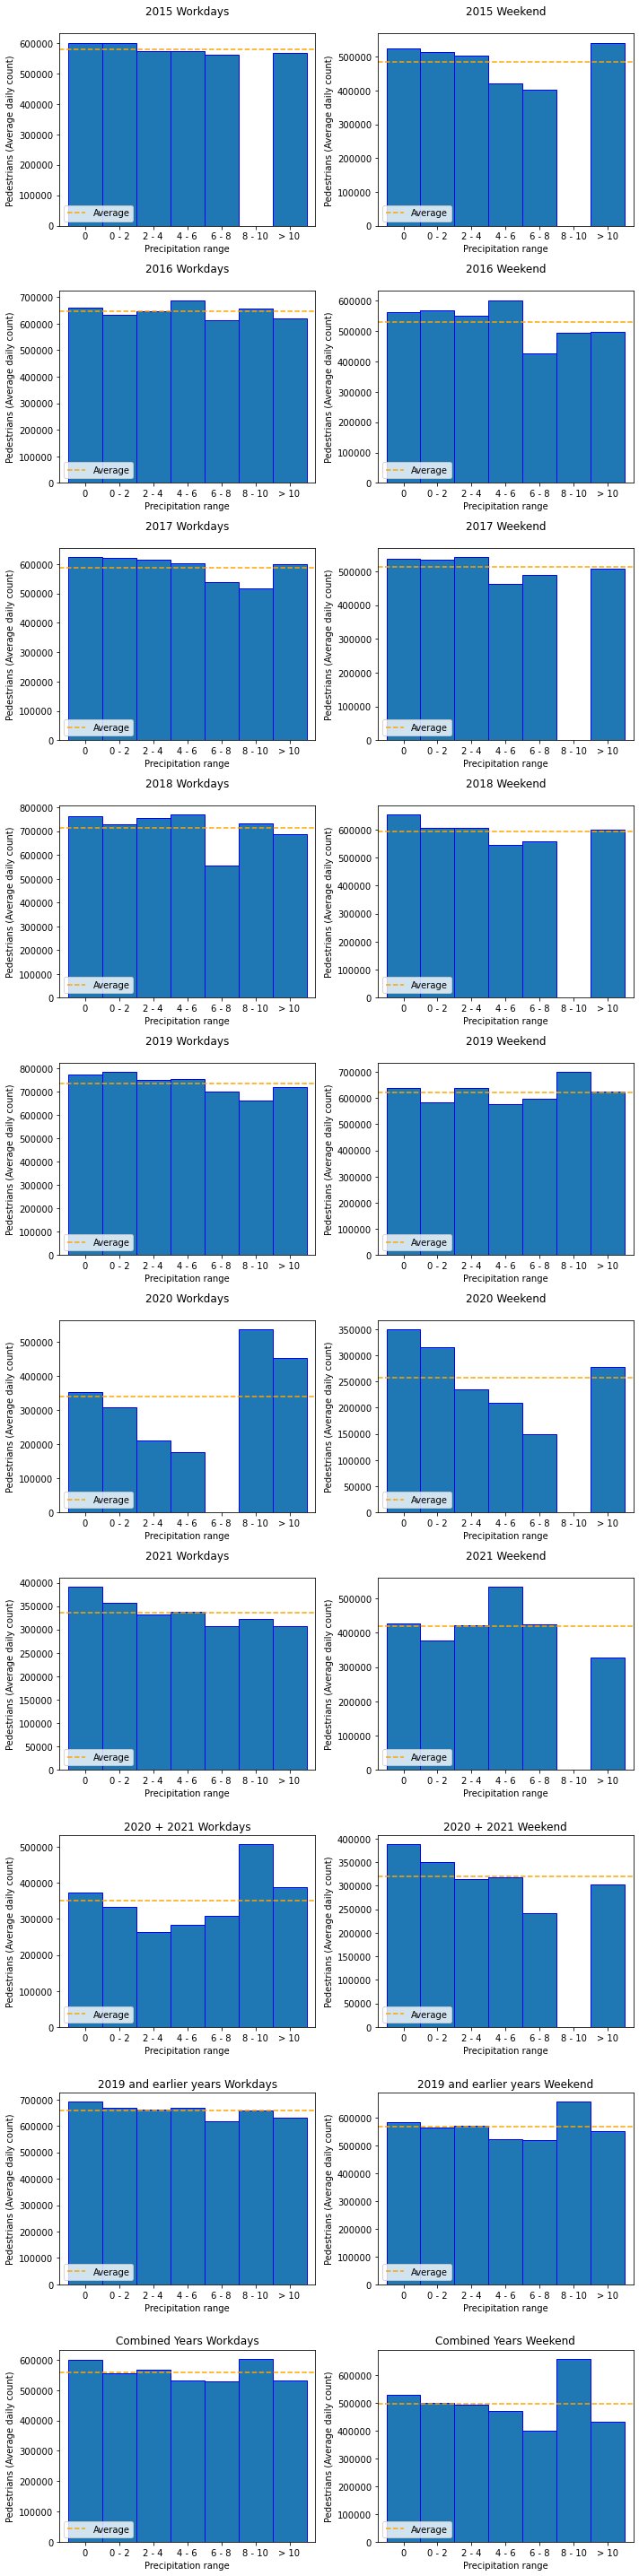

In [33]:
plotData(getRainData,'Precipitation',360)

In [34]:
def getWindData(year, isWeekend = False):
    xValues = []
    xLabels = []
    #Filter the data with our prevously defined helper function
    df_wf = filterData(df_w, year, isWeekend)
    
    #Define 5 custom bins for wind-speed ranges
    xValues.append(df_wf[(df_wf.prcp > 0) & (df_wf.wspd <= 10)].walker_counts.mean())
    xLabels.append('≤ 10')
    
    xValues.append(df_wf[(df_wf.prcp > 10) & (df_wf.wspd <= 15)].walker_counts.mean())
    xLabels.append('10 - 15')
    
    xValues.append(df_wf[(df_wf.prcp > 15) & (df_wf.wspd <= 20)].walker_counts.mean())
    xLabels.append('15 - 20')
    
    xValues.append(df_wf[(df_wf.prcp > 20) & (df_wf.wspd <= 25)].walker_counts.mean())
    xLabels.append('20 - 25')
        
    xValues.append(df_wf[(df_wf.prcp > 25)].walker_counts.mean())
    xLabels.append('> 25')
    
    return pd.Series(xValues, index = xLabels)

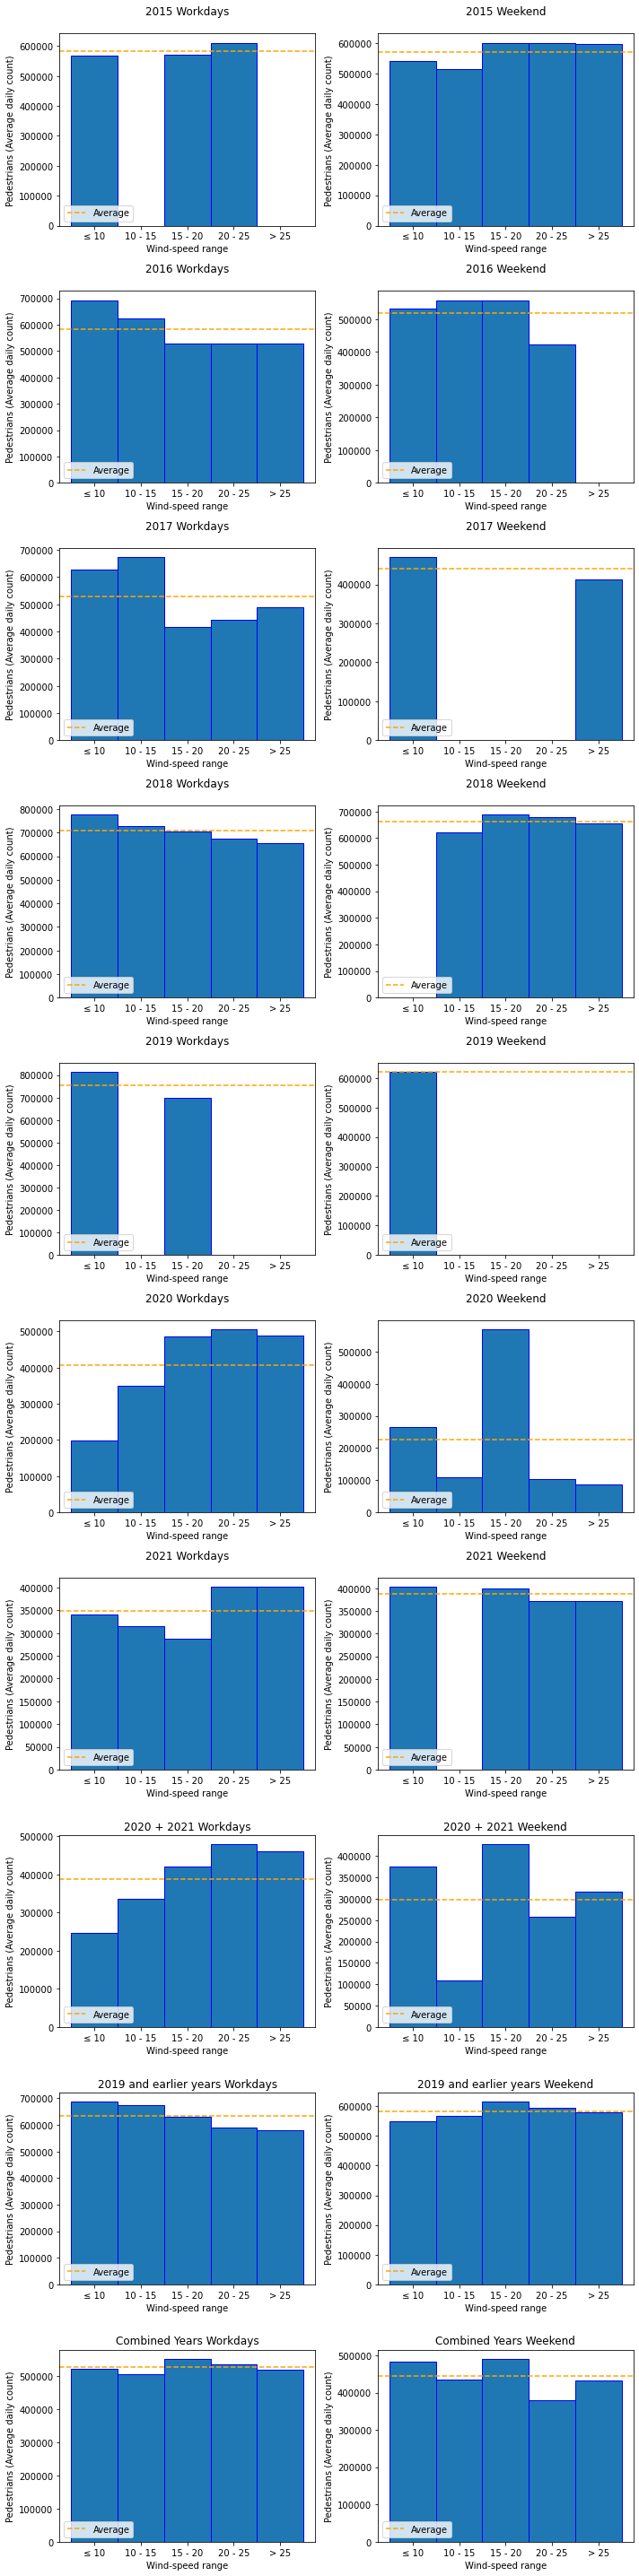

In [35]:
plotData(getWindData,'Wind-speed')

In [36]:
def getTempData(year, isWeekend = False):
    xValues = []
    xLabels = []
    #Filter the data with our prevously defined helper function
    df_wf = filterData(df_w, year, isWeekend)
    
    xValues.append(df_wf[(df_wf.tavg <= 8)].walker_counts.mean())
    #Add a label for the first bin to just show pedestrian data of less than 8 degrees
    xLabels.append('≤ 8')
    
    #Define and add 6 bins addition for temperature with a 3 degree interval
    for n in range(8,25,3):
        xValues.append(df_wf[(df_wf.prcp > n) & (df_wf.tavg <= n+3)].walker_counts.mean())
        xLabels.append(f'{n} - {n+3}')
    #Add a final bin for above 26 degrees
    xValues.append(df_wf[(df_wf.tavg > 26)].walker_counts.mean())

    xLabels.append('> 26')
    return pd.Series(xValues, index = xLabels)

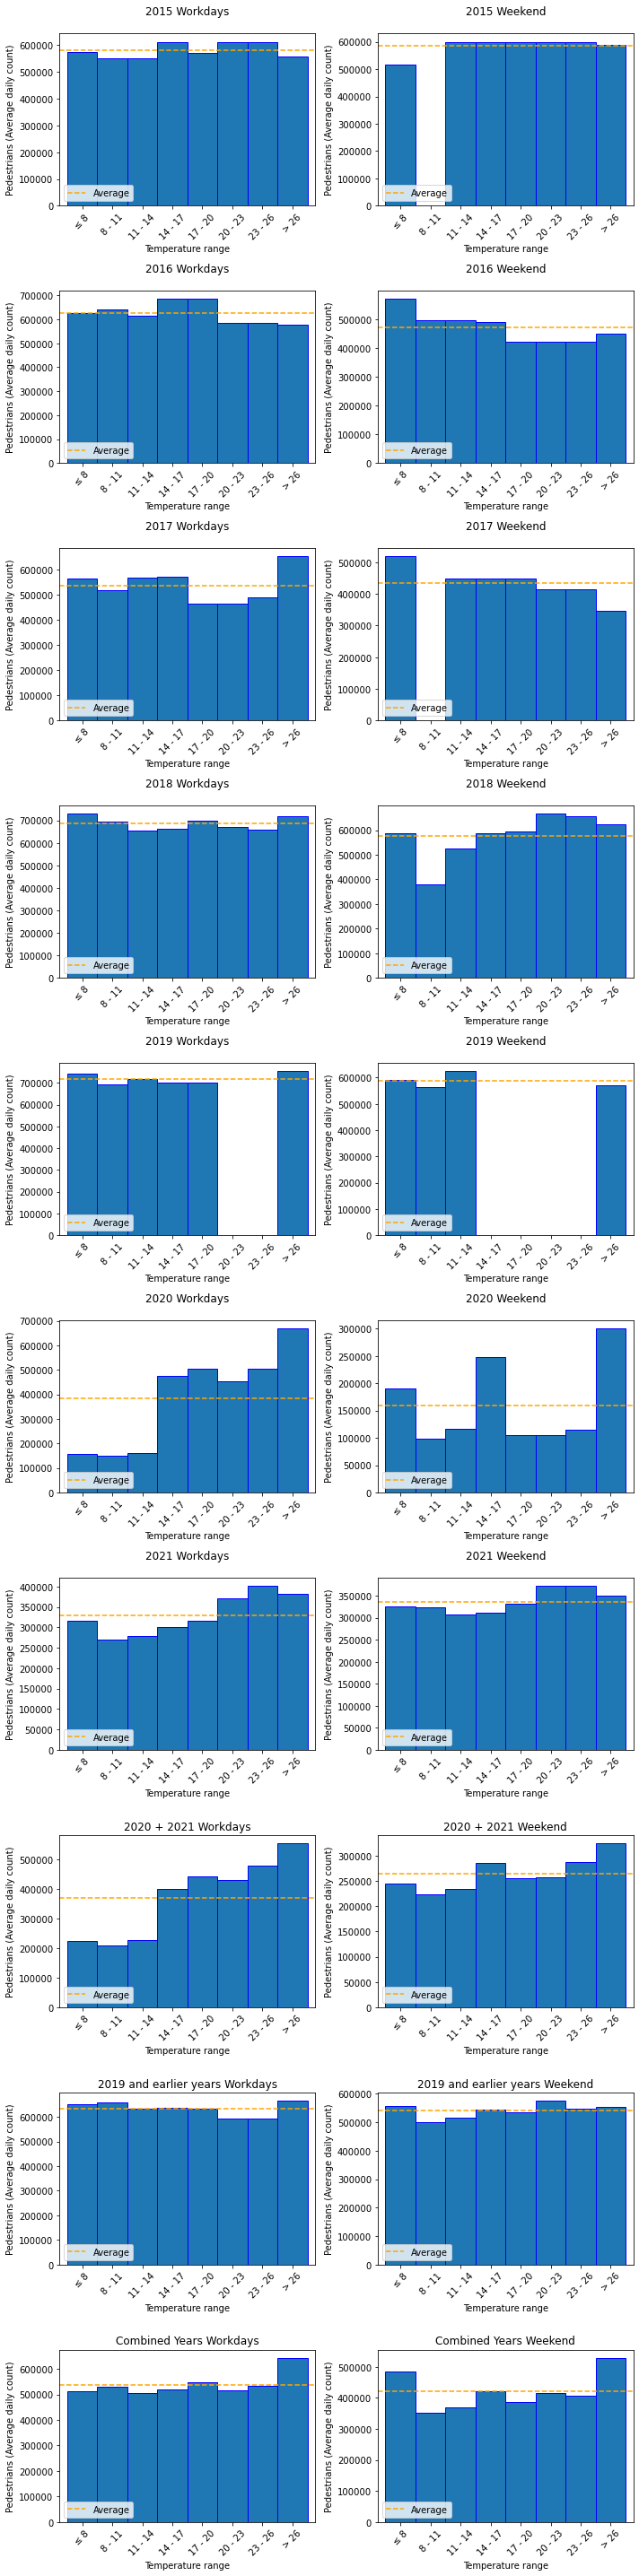

In [37]:
plotData(getTempData,'Temperature',45)

## Genre
### Which genre of story did we use?
We decided to run with the magazine style. Truthfully, it was because this way we could best work on our graphs to the best of our ability without having to worry with implementing them in a third party platform/website structure. We would have liked to just focus on the tools we had been taught during class, and the magazine style article allowed us to do just that.

After the decision, however, we leveraged the use of the magazine style to lay additional weight on the narrative part of the article. We could find literary ways to engage with the user instead of attempting to wow them with flashy web parts.

We then supplemented this with some streamlined, light and pretty plots to provide the users with easily digestible 'breaks'.

### Which tools did we use from each of the 3 categories of Visual Narrative. Why?
A **consistent visual platform** is used, though its use was rather subconscious than decided. Plots with similar styles and an overall sense of 'appearance' for the article as a whole is naturally appealing and was a simple goal to strive for.

We use little explosive highlighting, but did make use of some literary highlighting tools. Giving the introductory text a thick font leads the user into the article and the traditional use of chapters and paragraphs makes reading less strenuous.

Due to the magazine style of our article and the conservative presentation of our plots, other visual tools were not quite applicable.

### Which tools did we use from each of the 3 categories of Narrative Structure. Why?
Our intent was to write with a **User Directed Path**. We supposed we could lead the user through the data from the simplest plots first, for example simple plots over pedestrian activity across the years, into heavier material such as corellations, to finally conclude with the most technically complicated data; our predictive model. This way we figured that a regular reader would be engaged by the simple premises early on, and hang on through the slightly tougher material throughout.

Additionally, a reader unintestered in heavier material would still be have followed along for some of the article and caught at least some of the interesting points we would like to send across.

Overall, the **interactivity** of our narrative structure is lacklustre, but we don't find it to much of a detriment - the goal of our article is to guide the reader through literary structure instead of interactive tools.

We make use of **captions and headlines** to make the article easier to digest. Additionally, while we actively *avoid* drawing on **repeated comments** (due to the nature of the topic being, in our opinion, lightweight and therefore not requiring repitition for understanding) we *do* exploit the **introductory text** and later a short **synopsis**, concealed as narrative devices to first greet the reader and subsequently wean them off the text.

## Visualizations
### Explain the visualizations we've chosen and why we've chosen them.
We've been particularly fond of **bar plots** throughout the article. We simply find that these present the data most succinctly. It is easy to see any trends (which were the objective of our subject matter) and they rarely 'hide' any data between graph points. While we initially wished to use line graphs simply for the sake of switching things up, we simply could not find a suitable occasion for their use. Line graphs tend to lend themselves to continuum situations where a bar plot would be showing too many bars on the x-axis. Our only graphs which could make use of this are located here in the explainer notebook, but never made the cut to the article.

Additionally, heat maps and location maps provide us with a strong overview over the geographical properties of the pedestrian activity. Visualizing walkers can be tough in numbers and a columns, so providing a visual overview of what is going on provides readers a better understanding of the story being told. While heatmaps are not much use in the subsequent data analysis of the story, they provide a fundamentental background for which the rest of the narrative rests on. Users can imagine the streets where the story takes place and the citizens walking about.

Finally, we visualized the top three layers of our decision tree by drawing them in a different program. This gives the lay reader a chance to understand the steps a decision tree walks through to conduct predictions.

## Discussion
### What went well?
We are very satisfied with the exploration of data we have made, and the data analysis went well. We believe we have extracted what could be extracted from the data sets and we have had a good time exploring correlations.

The article came out nicely, and we are proud to present our findings (or perhaps rather, the lack thereof!) We believe 

### What is still missing? What could be improved? Why?
While we are satisfied with the plots that made the cut to the article, we are not entirely satisfied with how they got a bit too identical. We would have preferred some more mixing up in graph styles to give viewers a more organic experience. Additionally, while we like the website we put together by the end of the project, we would have appreciated time set off to actually prettify the presentation. We felt there was a disconnect between presentation of our chosen user-facing project result and what was actually the focus of the grading; content of our products.

The greatest improvement we could make is to take the study to the next step: By gathering similar pedestrian and weather data from cities all over the world and looking at the same correlations as here. Scaling up would of course require a linear addition of work, however, and we do earnestly believe that we would see similar results. People walk simply because they need to, not because they want to. Despite this, we're satisfied with seeing some results (we cling to the correlations against precipiation in the weekends like fanatics!) and are glad that we explored this topic. It was interesting to dive into the science behind some basic assumptions we had established about human nature and desire.

## Contributions
**Sune, 